# init

In [1]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/My Drive/root ap/Epoch and Batches

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/root ap/Epoch and Batches


In [2]:
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from pprint import pprint as pprint

# EnB

In [3]:
from EpochAndBatches import EpochAndBatches as EnB 

# unit test

In [4]:
config = {}
config['n_epoch'] = 20
config['batch_size'] = 4096
config['n_batch'] = 30
config['device'] = 'cuda:0'
d = config['device']

In [5]:
enb = EnB(config['n_epoch'],config['n_batch'])
enb.config = config
# enb.verbose = 9000

enb.save()

pprint(vars(enb))

EnB | msg = EnB: Epoch And Batches START
{'config': {'batch_size': 4096,
            'device': 'cuda:0',
            'n_batch': 30,
            'n_epoch': 20},
 'cwd': '/gdrive/My Drive/root ap/Epoch and Batches',
 'dflog':    i_batch  i_epoch  key label                         value
0     -1.0     -1.0  msg   msg  EnB: Epoch And Batches START,
 'enb_output_filepath': 'default_run_1600324884_694.enb',
 'i_batch': -1,
 'i_epoch': -1,
 'is_save_per_batch': False,
 'is_save_per_epoch': True,
 'is_save_per_log': False,
 'n_batch': 30,
 'n_epoch': 20,
 'pid': 694,
 'project_name': 'Default Project',
 'run_name': 'default_run_1600324884_694',
 'script_start_time': 1600324884.2259302,
 'sweep_name': 'Default Sweep',
 'verbose': 15}


In [6]:
net = torch.nn.Sequential(torch.nn.Linear(1, 4096),
                          torch.nn.ReLU(),
                          torch.nn.Linear(4096, 1)).to(d)

o = torch.optim.Adam(net.parameters())

loss_mae = torch.nn.L1Loss()
loss_mse = torch.nn.MSELoss()

## fit

In [7]:
enb.best_epoch = -1
enb.best_val_loss = sys.float_info.max
for i_epoch in range(config['n_epoch']):
    enb.next_epoch()
    z_mae = 0
    z_mse = 0
    zmetric1 = 0
    zmetric2 = 0
    # train one epoch
    for i_batch in range(config['n_batch']):
        enb.next_batch()
        # forward
        net.train()
        o.zero_grad()
        ix = torch.rand(config['batch_size'],1).to(d) * 4 - 2
        iy = ix**2
        ih = net(ix)
        mae = loss_mae(ih,iy)
        mse = loss_mse(ih,iy)
        loss = mae**2 + mse
        # backward
        loss.backward()
        o.step()
        # metrics
        metric1 = mae.item() + mse.item()
        metric2 = mae.item() - mse.item()
        z_mae += mae.item()
        z_mse += mse.item()
        zmetric1 += metric1
        zmetric2 += metric2
        #enb
        enb.log_batch('loss:mae',mae.item(),35)
        enb.log_batch('loss:mse',mse.item(),35)
        enb.log_batch('metric:1',metric1,35)
        enb.log_batch('metric:2',metric2,35)
    z_mae /= config['n_batch']
    z_mse /= config['n_batch']
    zmetric1 /= config['n_batch']
    zmetric2 /= config['n_batch']
    enb.log_epoch('loss:mae',z_mae,35)
    enb.log_epoch('loss:mse',z_mse,35)
    enb.log_epoch('metric:1',zmetric1,35)
    enb.log_epoch('metric:2',zmetric2,35)
    enb.log_epoch('gpu-mem',str(torch.cuda.memory_reserved(d)),35)
    # validate one epoch
    net.eval()
    ix = torch.rand(config['batch_size']*5,1).to(d) *6 - 3
    iy = ix**2
    ih = net(ix)
    val_mae = loss_mae(ih,iy).item()
    val_mse = loss_mse(ih,iy).item()
    loss = val_mae**2 + val_mse
    val_metric1 = val_mae + val_mse
    val_metric2 = val_mae - val_mse
    enb.log_epoch('loss:val_mae',val_mae,35)
    enb.log_epoch('loss:val_mse',val_mse,35)
    enb.log_epoch('metric:1',val_metric1,35)
    enb.log_epoch('metric:2',val_metric2,35)
    enb.log_epoch('model:net_state_dict',net.state_dict(),35)
    enb.log_epoch('optim:adam_state_dict',o.state_dict(),35)
    if loss < enb.best_val_loss:
        enb.best_val_loss = loss
        enb.best_epoch = enb.i_epoch
        enb.best_model_state_dict = net.state_dict()
        enb.log_msg('New best_val_loss='+str(enb.best_val_loss))
        enb.best_val_mae = val_mae
        enb.best_val_mse = val_mse
        enb.best_val_metric1 = val_metric1
        enb.best_val_metric2 = val_metric2
#test
net.load_state_dict(enb.best_model_state_dict)
ix = torch.rand(config['batch_size']*5,1).to(d) * 8 - 4
iy = ix**2
ih = net(ix)
enb.tst_mae = loss_mae(ih,iy).item()
enb.tst_mse = loss_mse(ih,iy).item()
enb.tst_metric1 = enb.tst_mae + enb.tst_mse
enb.tst_metric2 = enb.tst_mae - enb.tst_mse
enb.save()

EnB | msg = next_epoch: 0/20  |  00:00:00 + 00:00:00 = 00:00:00 / 00:00:00
EnB | msg = New best_val_loss=0.6156449827258257
EnB | msg = next_epoch: 1/20  |  00:00:01 + 00:00:20 = 00:00:01 / 00:00:21
EnB | msg = New best_val_loss=0.4570068904295903
EnB | msg = next_epoch: 2/20  |  00:00:02 + 00:00:19 = 00:00:01 / 00:00:21
EnB | msg = New best_val_loss=0.3574326042167053
EnB | msg = next_epoch: 3/20  |  00:00:03 + 00:00:18 = 00:00:01 / 00:00:21
EnB | msg = New best_val_loss=0.2825830862922827
EnB | msg = next_epoch: 4/20  |  00:00:04 + 00:00:17 = 00:00:01 / 00:00:21
EnB | msg = New best_val_loss=0.24570834631221516
EnB | msg = next_epoch: 5/20  |  00:00:05 + 00:00:16 = 00:00:01 / 00:00:21
EnB | msg = New best_val_loss=0.23792475520781609
EnB | msg = next_epoch: 6/20  |  00:00:06 + 00:00:15 = 00:00:01 / 00:00:21
EnB | msg = New best_val_loss=0.2184428196013235
EnB | msg = next_epoch: 7/20  |  00:00:07 + 00:00:14 = 00:00:01 / 00:00:21
EnB | msg = New best_val_loss=0.20539241449972523
EnB |

# load

In [8]:
enb2 = EnB.load(enb.enb_output_filepath)

EnB loading  default_run_1600324884_694.enb  ...
EnB  default_run_1600324884_694.enb  loaded.


In [16]:
d_enb = vars(enb2)
for k,v in d_enb.items():
    print(k,type(v))

project_name <class 'str'>
sweep_name <class 'str'>
dflog <class 'pandas.core.frame.DataFrame'>
script_start_time <class 'float'>
pid <class 'int'>
cwd <class 'str'>
verbose <class 'int'>
n_epoch <class 'int'>
n_batch <class 'int'>
i_epoch <class 'int'>
i_batch <class 'int'>
is_save_per_log <class 'bool'>
is_save_per_batch <class 'bool'>
is_save_per_epoch <class 'bool'>
run_name <class 'str'>
enb_output_filepath <class 'str'>
config <class 'dict'>
best_epoch <class 'int'>
best_val_loss <class 'float'>
fit_start_time <class 'float'>
i_batch_start_time <class 'float'>
best_model_state_dict <class 'collections.OrderedDict'>
best_val_mae <class 'float'>
best_val_mse <class 'float'>
best_val_metric1 <class 'float'>
best_val_metric2 <class 'float'>
tst_mae <class 'float'>
tst_mse <class 'float'>
tst_metric1 <class 'float'>
tst_metric2 <class 'float'>


# display

In [10]:
for il in enb2.dflog['label'].unique():
    for ik in enb2.dflog['key'].loc[enb2.dflog['label']==il].unique():
        print(il,ik)

msg msg
per_epoch time:elapsed
per_epoch time:total
per_epoch time:left
per_epoch time:each
per_epoch loss:mae
per_epoch loss:mse
per_epoch metric:1
per_epoch metric:2
per_epoch gpu-mem
per_epoch loss:val_mae
per_epoch loss:val_mse
per_epoch model:net_state_dict
per_epoch optim:adam_state_dict
per_batch time:elapsed
per_batch time:total
per_batch time:left
per_batch time:each
per_batch loss:mae
per_batch loss:mse
per_batch metric:1
per_batch metric:2


In [11]:
for il in enb2.dflog['label'].unique():
    for ik in enb2.dflog['key'].loc[enb2.dflog['label']==il].unique():
        print(il,ik)
        display(enb2.dflog.loc[(enb2.dflog['key']==ik) & (enb2.dflog['label']==il)])

msg msg


,i_batch,i_epoch,key,label,value
0,-1.0,-1.0,msg,msg,EnB: Epoch And Batches START
1,-1.0,0.0,msg,msg,next_epoch: 0/20 | 00:00:00 + 00:00:00 = 00:...
257,29.0,0.0,msg,msg,New best_val_loss=0.6156449827258257
258,-1.0,1.0,msg,msg,next_epoch: 1/20 | 00:00:01 + 00:00:20 = 00:...
514,29.0,1.0,msg,msg,New best_val_loss=0.4570068904295903
515,-1.0,2.0,msg,msg,next_epoch: 2/20 | 00:00:02 + 00:00:19 = 00:...
771,29.0,2.0,msg,msg,New best_val_loss=0.3574326042167053
772,-1.0,3.0,msg,msg,next_epoch: 3/20 | 00:00:03 + 00:00:18 = 00:...
1028,29.0,3.0,msg,msg,New best_val_loss=0.2825830862922827
1029,-1.0,4.0,msg,msg,next_epoch: 4/20 | 00:00:04 + 00:00:17 = 00:...


per_epoch time:elapsed


,i_batch,i_epoch,key,label,value
2,NaN,0.0,time:elapsed,per_epoch,0
259,NaN,1.0,time:elapsed,per_epoch,1.0845
516,NaN,2.0,time:elapsed,per_epoch,2.15855
773,NaN,3.0,time:elapsed,per_epoch,3.22961
1030,NaN,4.0,time:elapsed,per_epoch,4.30641
1287,NaN,5.0,time:elapsed,per_epoch,5.38274
1544,NaN,6.0,time:elapsed,per_epoch,6.46934
1801,NaN,7.0,time:elapsed,per_epoch,7.54712
2058,NaN,8.0,time:elapsed,per_epoch,8.62646
2314,NaN,9.0,time:elapsed,per_epoch,9.70078


per_epoch time:total


,i_batch,i_epoch,key,label,value
3,NaN,0.0,time:total,per_epoch,0
260,NaN,1.0,time:total,per_epoch,21.6899
517,NaN,2.0,time:total,per_epoch,21.5855
774,NaN,3.0,time:total,per_epoch,21.5307
1031,NaN,4.0,time:total,per_epoch,21.5321
1288,NaN,5.0,time:total,per_epoch,21.531
1545,NaN,6.0,time:total,per_epoch,21.5645
1802,NaN,7.0,time:total,per_epoch,21.5632
2059,NaN,8.0,time:total,per_epoch,21.5661
2315,NaN,9.0,time:total,per_epoch,21.5573


per_epoch time:left


,i_batch,i_epoch,key,label,value
4,NaN,0.0,time:left,per_epoch,0
261,NaN,1.0,time:left,per_epoch,20.6054
518,NaN,2.0,time:left,per_epoch,19.427
775,NaN,3.0,time:left,per_epoch,18.3011
1032,NaN,4.0,time:left,per_epoch,17.2257
1289,NaN,5.0,time:left,per_epoch,16.1482
1546,NaN,6.0,time:left,per_epoch,15.0951
1803,NaN,7.0,time:left,per_epoch,14.0161
2060,NaN,8.0,time:left,per_epoch,12.9397
2316,NaN,9.0,time:left,per_epoch,11.8565


per_epoch time:each


,i_batch,i_epoch,key,label,value
5,NaN,0.0,time:each,per_epoch,0
262,NaN,1.0,time:each,per_epoch,1.0845
519,NaN,2.0,time:each,per_epoch,1.07928
776,NaN,3.0,time:each,per_epoch,1.07654
1033,NaN,4.0,time:each,per_epoch,1.0766
1290,NaN,5.0,time:each,per_epoch,1.07655
1547,NaN,6.0,time:each,per_epoch,1.07822
1804,NaN,7.0,time:each,per_epoch,1.07816
2061,NaN,8.0,time:each,per_epoch,1.07831
2317,NaN,9.0,time:each,per_epoch,1.07786


per_epoch loss:mae


,i_batch,i_epoch,key,label,value
246,NaN,0.0,loss:mae,per_epoch,0.489335
503,NaN,1.0,loss:mae,per_epoch,0.102269
760,NaN,2.0,loss:mae,per_epoch,0.0301363
1017,NaN,3.0,loss:mae,per_epoch,0.0157085
1274,NaN,4.0,loss:mae,per_epoch,0.0111635
1531,NaN,5.0,loss:mae,per_epoch,0.00795995
1788,NaN,6.0,loss:mae,per_epoch,0.0057916
2045,NaN,7.0,loss:mae,per_epoch,0.00463259
2302,NaN,8.0,loss:mae,per_epoch,0.00408322
2558,NaN,9.0,loss:mae,per_epoch,0.00377736


per_epoch loss:mse


,i_batch,i_epoch,key,label,value
247,NaN,0.0,loss:mse,per_epoch,0.49112
504,NaN,1.0,loss:mse,per_epoch,0.0182449
761,NaN,2.0,loss:mse,per_epoch,0.00157353
1018,NaN,3.0,loss:mse,per_epoch,0.000427152
1275,NaN,4.0,loss:mse,per_epoch,0.000203408
1532,NaN,5.0,loss:mse,per_epoch,0.000107406
1789,NaN,6.0,loss:mse,per_epoch,6.13753e-05
2046,NaN,7.0,loss:mse,per_epoch,4.11486e-05
2303,NaN,8.0,loss:mse,per_epoch,3.11334e-05
2559,NaN,9.0,loss:mse,per_epoch,2.59804e-05


per_epoch metric:1


,i_batch,i_epoch,key,label,value
248,NaN,0.0,metric:1,per_epoch,0.980455
253,NaN,0.0,metric:1,per_epoch,0.864738
505,NaN,1.0,metric:1,per_epoch,0.120514
510,NaN,1.0,metric:1,per_epoch,0.675478
762,NaN,2.0,metric:1,per_epoch,0.0317098
767,NaN,2.0,metric:1,per_epoch,0.55632
1019,NaN,3.0,metric:1,per_epoch,0.0161356
1024,NaN,3.0,metric:1,per_epoch,0.463872
1276,NaN,4.0,metric:1,per_epoch,0.0113669
1281,NaN,4.0,metric:1,per_epoch,0.415771


per_epoch metric:2


,i_batch,i_epoch,key,label,value
249,NaN,0.0,metric:2,per_epoch,-0.00178569
254,NaN,0.0,metric:2,per_epoch,0.0750187
506,NaN,1.0,metric:2,per_epoch,0.0840241
511,NaN,1.0,metric:2,per_epoch,-0.0306056
763,NaN,2.0,metric:2,per_epoch,0.0285627
768,NaN,2.0,metric:2,per_epoch,-0.00848353
1020,NaN,3.0,metric:2,per_epoch,0.0152813
1025,NaN,3.0,metric:2,per_epoch,0.0118707
1277,NaN,4.0,metric:2,per_epoch,0.01096
1282,NaN,4.0,metric:2,per_epoch,0.0187656


per_epoch gpu-mem


,i_batch,i_epoch,key,label,value
250,NaN,0.0,gpu-mem,per_epoch,203423744
507,NaN,1.0,gpu-mem,per_epoch,874512384
764,NaN,2.0,gpu-mem,per_epoch,874512384
1021,NaN,3.0,gpu-mem,per_epoch,874512384
1278,NaN,4.0,gpu-mem,per_epoch,874512384
1535,NaN,5.0,gpu-mem,per_epoch,874512384
1792,NaN,6.0,gpu-mem,per_epoch,874512384
2049,NaN,7.0,gpu-mem,per_epoch,874512384
2306,NaN,8.0,gpu-mem,per_epoch,874512384
2562,NaN,9.0,gpu-mem,per_epoch,874512384


per_epoch loss:val_mae


,i_batch,i_epoch,key,label,value
251,NaN,0.0,loss:val_mae,per_epoch,0.469878
508,NaN,1.0,loss:val_mae,per_epoch,0.322436
765,NaN,2.0,loss:val_mae,per_epoch,0.273918
1022,NaN,3.0,loss:val_mae,per_epoch,0.237871
1279,NaN,4.0,loss:val_mae,per_epoch,0.217268
1536,NaN,5.0,loss:val_mae,per_epoch,0.212822
1793,NaN,6.0,loss:val_mae,per_epoch,0.200923
2050,NaN,7.0,loss:val_mae,per_epoch,0.19323
2307,NaN,8.0,loss:val_mae,per_epoch,0.193747
2563,NaN,9.0,loss:val_mae,per_epoch,0.194203


per_epoch loss:val_mse


,i_batch,i_epoch,key,label,value
252,NaN,0.0,loss:val_mse,per_epoch,0.394859
509,NaN,1.0,loss:val_mse,per_epoch,0.353042
766,NaN,2.0,loss:val_mse,per_epoch,0.282402
1023,NaN,3.0,loss:val_mse,per_epoch,0.226
1280,NaN,4.0,loss:val_mse,per_epoch,0.198503
1537,NaN,5.0,loss:val_mse,per_epoch,0.192632
1794,NaN,6.0,loss:val_mse,per_epoch,0.178073
2051,NaN,7.0,loss:val_mse,per_epoch,0.168054
2308,NaN,8.0,loss:val_mse,per_epoch,0.168264
2564,NaN,9.0,loss:val_mse,per_epoch,0.16667


per_epoch model:net_state_dict


,i_batch,i_epoch,key,label,value
255,NaN,0.0,model:net_state_dict,per_epoch,"{'0.weight': [[tensor(0.5510, device='cuda:0')..."
512,NaN,1.0,model:net_state_dict,per_epoch,"{'0.weight': [[tensor(0.5510, device='cuda:0')..."
769,NaN,2.0,model:net_state_dict,per_epoch,"{'0.weight': [[tensor(0.5510, device='cuda:0')..."
1026,NaN,3.0,model:net_state_dict,per_epoch,"{'0.weight': [[tensor(0.5510, device='cuda:0')..."
1283,NaN,4.0,model:net_state_dict,per_epoch,"{'0.weight': [[tensor(0.5510, device='cuda:0')..."
1540,NaN,5.0,model:net_state_dict,per_epoch,"{'0.weight': [[tensor(0.5510, device='cuda:0')..."
1797,NaN,6.0,model:net_state_dict,per_epoch,"{'0.weight': [[tensor(0.5510, device='cuda:0')..."
2054,NaN,7.0,model:net_state_dict,per_epoch,"{'0.weight': [[tensor(0.5510, device='cuda:0')..."
2311,NaN,8.0,model:net_state_dict,per_epoch,"{'0.weight': [[tensor(0.5510, device='cuda:0')..."
2567,NaN,9.0,model:net_state_dict,per_epoch,"{'0.weight': [[tensor(0.5510, device='cuda:0')..."


per_epoch optim:adam_state_dict


,i_batch,i_epoch,key,label,value
256,NaN,0.0,optim:adam_state_dict,per_epoch,"{'state': {0: {'step': 600, 'exp_avg': tensor(..."
513,NaN,1.0,optim:adam_state_dict,per_epoch,"{'state': {0: {'step': 600, 'exp_avg': tensor(..."
770,NaN,2.0,optim:adam_state_dict,per_epoch,"{'state': {0: {'step': 600, 'exp_avg': tensor(..."
1027,NaN,3.0,optim:adam_state_dict,per_epoch,"{'state': {0: {'step': 600, 'exp_avg': tensor(..."
1284,NaN,4.0,optim:adam_state_dict,per_epoch,"{'state': {0: {'step': 600, 'exp_avg': tensor(..."
1541,NaN,5.0,optim:adam_state_dict,per_epoch,"{'state': {0: {'step': 600, 'exp_avg': tensor(..."
1798,NaN,6.0,optim:adam_state_dict,per_epoch,"{'state': {0: {'step': 600, 'exp_avg': tensor(..."
2055,NaN,7.0,optim:adam_state_dict,per_epoch,"{'state': {0: {'step': 600, 'exp_avg': tensor(..."
2312,NaN,8.0,optim:adam_state_dict,per_epoch,"{'state': {0: {'step': 600, 'exp_avg': tensor(..."
2568,NaN,9.0,optim:adam_state_dict,per_epoch,"{'state': {0: {'step': 600, 'exp_avg': tensor(..."


per_batch time:elapsed


,i_batch,i_epoch,key,label,value
6,0.0,0.0,time:elapsed,per_batch,0
14,1.0,0.0,time:elapsed,per_batch,0.0342147
22,2.0,0.0,time:elapsed,per_batch,0.0653546
30,3.0,0.0,time:elapsed,per_batch,0.0966768
38,4.0,0.0,time:elapsed,per_batch,0.127857
...,...,...,...,...,...
5088,25.0,19.0,time:elapsed,per_batch,0.863674
5096,26.0,19.0,time:elapsed,per_batch,0.897095
5104,27.0,19.0,time:elapsed,per_batch,0.930181
5112,28.0,19.0,time:elapsed,per_batch,0.963495


per_batch time:total


,i_batch,i_epoch,key,label,value
7,0.0,0.0,time:total,per_batch,0
15,1.0,0.0,time:total,per_batch,1.02644
23,2.0,0.0,time:total,per_batch,0.980319
31,3.0,0.0,time:total,per_batch,0.966768
39,4.0,0.0,time:total,per_batch,0.958931
...,...,...,...,...,...
5089,25.0,19.0,time:total,per_batch,1.03641
5097,26.0,19.0,time:total,per_batch,1.03511
5105,27.0,19.0,time:total,per_batch,1.03353
5113,28.0,19.0,time:total,per_batch,1.03232


per_batch time:left


,i_batch,i_epoch,key,label,value
8,0.0,0.0,time:left,per_batch,0
16,1.0,0.0,time:left,per_batch,0.992227
24,2.0,0.0,time:left,per_batch,0.914964
32,3.0,0.0,time:left,per_batch,0.870091
40,4.0,0.0,time:left,per_batch,0.831073
...,...,...,...,...,...
5090,25.0,19.0,time:left,per_batch,0.172735
5098,26.0,19.0,time:left,per_batch,0.138015
5106,27.0,19.0,time:left,per_batch,0.103353
5114,28.0,19.0,time:left,per_batch,0.0688211


per_batch time:each


,i_batch,i_epoch,key,label,value
9,0.0,0.0,time:each,per_batch,0
17,1.0,0.0,time:each,per_batch,0.0342147
25,2.0,0.0,time:each,per_batch,0.0326773
33,3.0,0.0,time:each,per_batch,0.0322256
41,4.0,0.0,time:each,per_batch,0.0319644
...,...,...,...,...,...
5091,25.0,19.0,time:each,per_batch,0.034547
5099,26.0,19.0,time:each,per_batch,0.0345036
5107,27.0,19.0,time:each,per_batch,0.0344511
5115,28.0,19.0,time:each,per_batch,0.0344105


per_batch loss:mae


,i_batch,i_epoch,key,label,value
10,0.0,0.0,loss:mae,per_batch,1.39187
18,1.0,0.0,loss:mae,per_batch,0.799705
26,2.0,0.0,loss:mae,per_batch,1.15159
34,3.0,0.0,loss:mae,per_batch,1.21475
42,4.0,0.0,loss:mae,per_batch,0.851634
...,...,...,...,...,...
5092,25.0,19.0,loss:mae,per_batch,0.00199799
5100,26.0,19.0,loss:mae,per_batch,0.0020025
5108,27.0,19.0,loss:mae,per_batch,0.00201816
5116,28.0,19.0,loss:mae,per_batch,0.00202666


per_batch loss:mse


,i_batch,i_epoch,key,label,value
11,0.0,0.0,loss:mse,per_batch,3.57444
19,1.0,0.0,loss:mse,per_batch,0.84209
27,2.0,0.0,loss:mse,per_batch,1.66108
35,3.0,0.0,loss:mse,per_batch,1.73666
43,4.0,0.0,loss:mse,per_batch,0.930269
...,...,...,...,...,...
5093,25.0,19.0,loss:mse,per_batch,7.47617e-06
5101,26.0,19.0,loss:mse,per_batch,7.34517e-06
5109,27.0,19.0,loss:mse,per_batch,7.97422e-06
5117,28.0,19.0,loss:mse,per_batch,7.95203e-06


per_batch metric:1


,i_batch,i_epoch,key,label,value
12,0.0,0.0,metric:1,per_batch,4.96631
20,1.0,0.0,metric:1,per_batch,1.64179
28,2.0,0.0,metric:1,per_batch,2.81267
36,3.0,0.0,metric:1,per_batch,2.95141
44,4.0,0.0,metric:1,per_batch,1.7819
...,...,...,...,...,...
5094,25.0,19.0,metric:1,per_batch,0.00200547
5102,26.0,19.0,metric:1,per_batch,0.00200984
5110,27.0,19.0,metric:1,per_batch,0.00202613
5118,28.0,19.0,metric:1,per_batch,0.00203461


per_batch metric:2


,i_batch,i_epoch,key,label,value
13,0.0,0.0,metric:2,per_batch,-2.18257
21,1.0,0.0,metric:2,per_batch,-0.0423852
29,2.0,0.0,metric:2,per_batch,-0.509488
37,3.0,0.0,metric:2,per_batch,-0.521905
45,4.0,0.0,metric:2,per_batch,-0.0786344
...,...,...,...,...,...
5095,25.0,19.0,metric:2,per_batch,0.00199052
5103,26.0,19.0,metric:2,per_batch,0.00199515
5111,27.0,19.0,metric:2,per_batch,0.00201018
5119,28.0,19.0,metric:2,per_batch,0.00201871


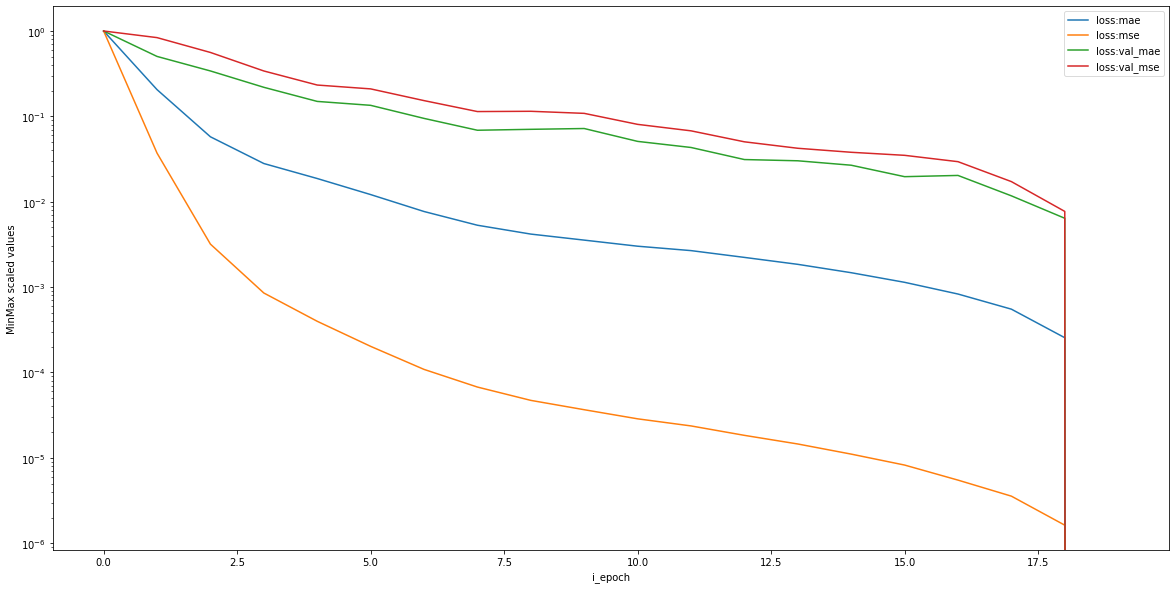

In [12]:
i_label = 'per_epoch'
i_key_group = 'loss'

plt.figure(figsize=[20,10])
plt.xlabel('i_epoch')
plt.ylabel('MinMax scaled values')
for ik in enb2.dflog['key'].loc[enb2.dflog['label']==i_label].unique():
    if ik[:len(i_key_group)] != i_key_group: continue
    tdf = enb2.dflog.loc[(enb2.dflog['key']==ik) & (enb2.dflog['label']==i_label)]
    plt.semilogy(tdf['i_epoch'],(tdf['value']-tdf['value'].min())/(tdf['value'].max()-tdf['value'].min()),label=ik)
plt.legend(framealpha=0.7)

# scratch

In [13]:
spam = torch.nn.Parameter(torch.randn(1).to(d))

In [14]:
print('',spam)
print('.detach()',spam.detach())
print('.cpu()',spam.cpu())
print('.item()',spam.item())
print('.detach().cpu()',spam.detach().cpu())
print('.detach().cpu().item()',spam.detach().cpu().item())

 Parameter containing:
tensor([-1.9656], device='cuda:0', requires_grad=True)
.detach() tensor([-1.9656], device='cuda:0')
.cpu() tensor([-1.9656], grad_fn=<CopyBackwards>)
.item() -1.9656450748443604
.detach().cpu() tensor([-1.9656])
.detach().cpu().item() -1.9656450748443604
